In [1]:
%pylab inline
import numpy as np
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import cartopy
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cmocean.cm as cmo
from matplotlib.patches import Polygon

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Populating the interactive namespace from numpy and matplotlib


In [2]:
savefig = True
figext = '.pdf'
datadir = '/Users/erik/Desktop/'

def savefig(fignum, figext=figext, savefig=savefig):
    figname = 'Fig%s%s' % (fignum, figext)
    if savefig:
        plt.savefig(figname)

In [3]:
fignum = '03_08'

#TODO

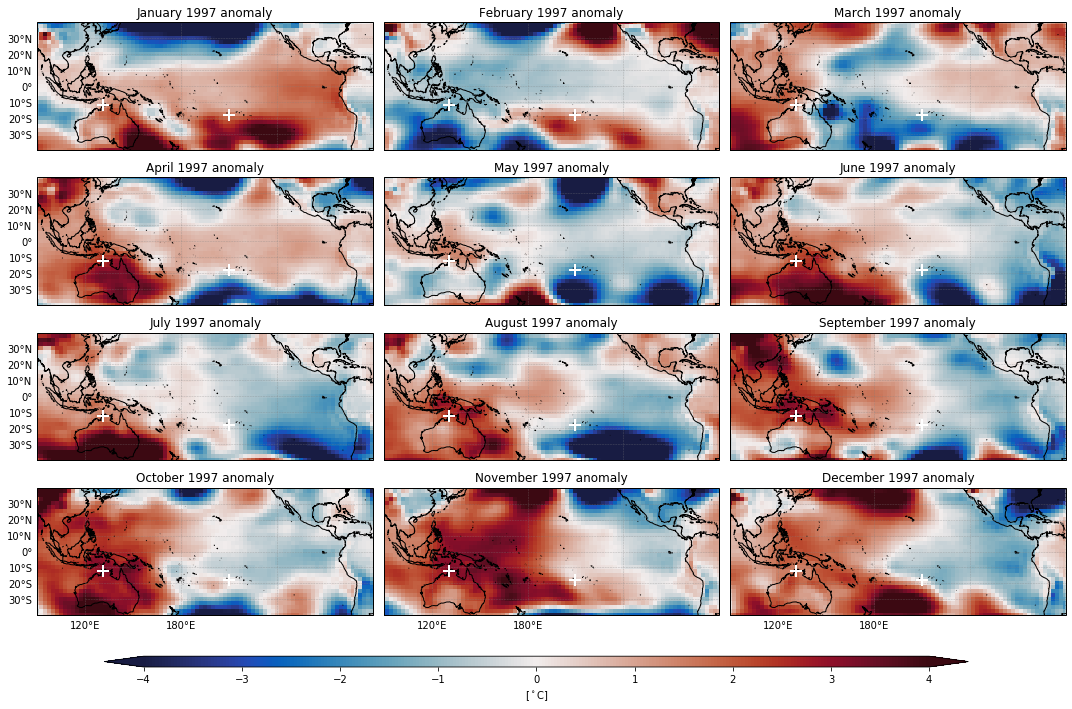

In [4]:
fignum = '06_23'

P = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lon=slice(90, 300), lat=slice(40, -40))

climatology = P.groupby("time.month").mean("time")
anomalies = P.groupby("time.month") - climatology

projection = cartopy.crs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(15, 10), constrained_layout=True)
hr = 2
gs = gridspec.GridSpec(5, 3, height_ratios=[hr, hr, hr, hr, 1]) 

for col in range(3):
    for row in range(4):
        ai = fig.add_subplot(gs[row, col], projection=projection)
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        p = anomalies.sel(time='1997-%.2d-01' % (row*3+col+1))
        a = p.plot(cmap=cmo.balance, vmin=-4, vmax=4,
                   transform=cartopy.crs.PlateCarree(), 
                   ax=ai, add_colorbar=False, rasterized=True)
        ai.plot([-150, 131], [-18, -12], 'w+', markersize=12, markeredgewidth=2, transform=cartopy.crs.PlateCarree())
        ai.set_title('%s anomaly' % p.time.dt.strftime('%B %Y').values)
        ai.set_extent([90, 300, -40, 40], crs=cartopy.crs.PlateCarree())
        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.FixedLocator([120, 180, 240, 300])
        if row == 3:
            gl.xlabels_bottom = True
            gl.xformatter = LONGITUDE_FORMATTER
        if col == 0:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
cax = plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[$^\circ$C]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()

savefig(fignum)

In [5]:
fignum = '06_28'

#TODO

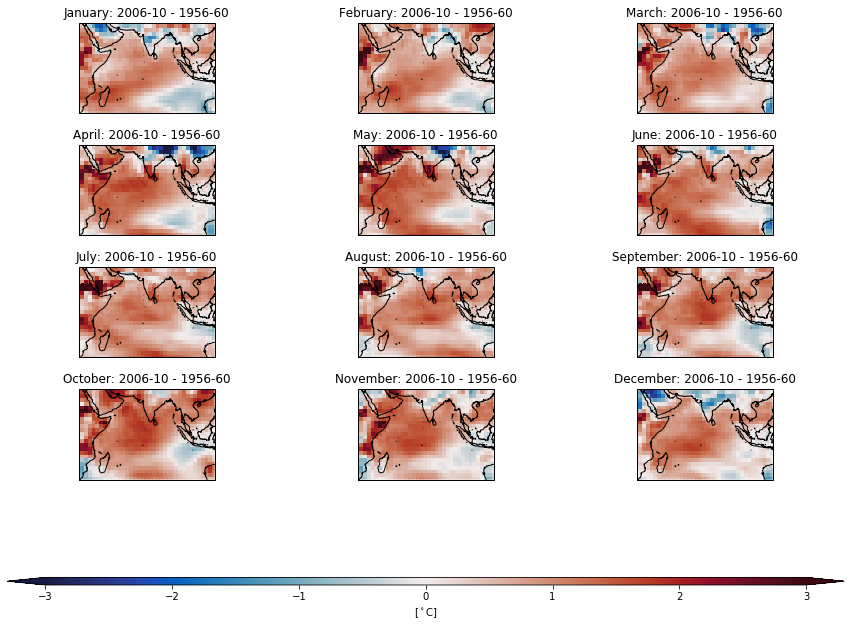

In [6]:
fignum = '06_31'

AT = xr.open_dataset(datadir+'NCEP/air.mon.mean.nc').air.sel(lon=slice(30, 120), lat=slice(30, -30))

air2000s = AT.sel(time=slice('2006-01-01', '2010-12-31')).groupby("time.month").mean('time')
air1950s = AT.sel(time=slice('1956-01-01', '1960-12-31')).groupby("time.month").mean('time')

air = air2000s - air1950s

projection = cartopy.crs.PlateCarree(central_longitude=75)
fig, ax = plt.subplots(4, 3, subplot_kw={'projection': projection}, figsize=(15, 12))

for i, ai in enumerate(ax.ravel()):
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    a = air.isel(month=i).plot(cmap=cmo.balance, vmin=-3, vmax=3,
               transform=cartopy.crs.PlateCarree(), 
               ax=ai, add_colorbar=False, rasterized=True)
    ai.set_title('%s: 2006-10 - 1956-60' % datetime.date(1900, i+1, 1).strftime('%B'))
    ai.set_extent([30, 120, -30, 30], crs=cartopy.crs.PlateCarree())

plt.subplots_adjust(hspace=0.35, wspace=0)
plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='both', label='[$^\circ$C]')
savefig(fignum)

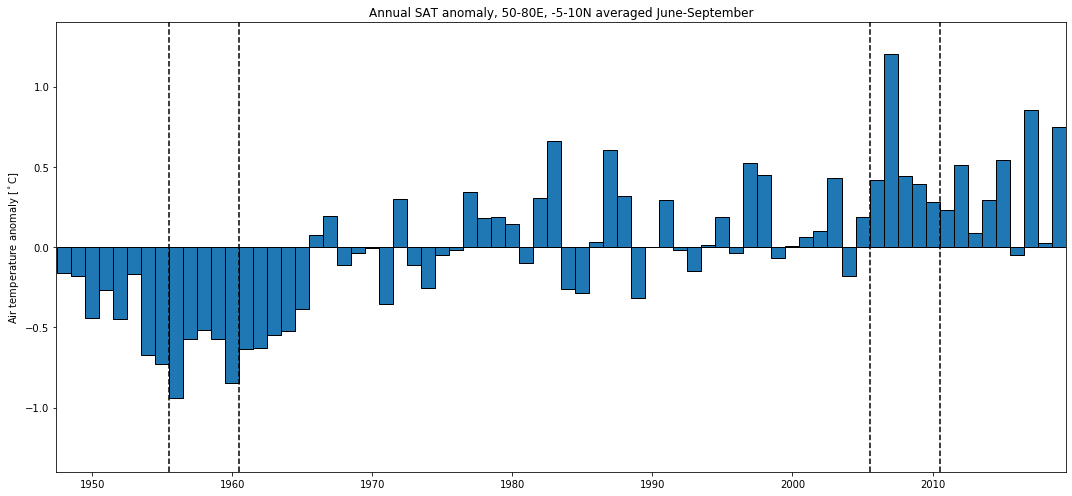

In [7]:
fignum = '06_32'

AT = xr.open_dataset(datadir+'NCEP/air.mon.mean.nc').air.sel(lon=slice(50, 80), lat=slice(10, -5)).mean('lon').mean('lat').sel(time=slice('1948-01-01', '2019-12-31'))
junsept = [True if ((i%12 > 4) and (i%12 < 9)) else False for i in range(len(AT.time.values))]
AT = AT.where(junsept)
AT = AT.groupby("time.year").mean('time')

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.bar(AT.year.values, (AT-AT.mean('year')).values, width=1, linewidth=1, edgecolor='k')
ax.vlines([1955.5, 1960.5, 2005.5, 2010.5], -1.4, 1.4, linestyle='--')
ax.set_xlim(AT.year.values[0]-0.55, AT.year.values[-1]+0.5)
ax.set_ylim(-1.4, 1.4)
ax.set_ylabel('Air temperature anomaly [$^\circ$C]')
ax.set_title('Annual SAT anomaly, 50-80E, -5-10N averaged June-September')
plt.tight_layout()
savefig(fignum)

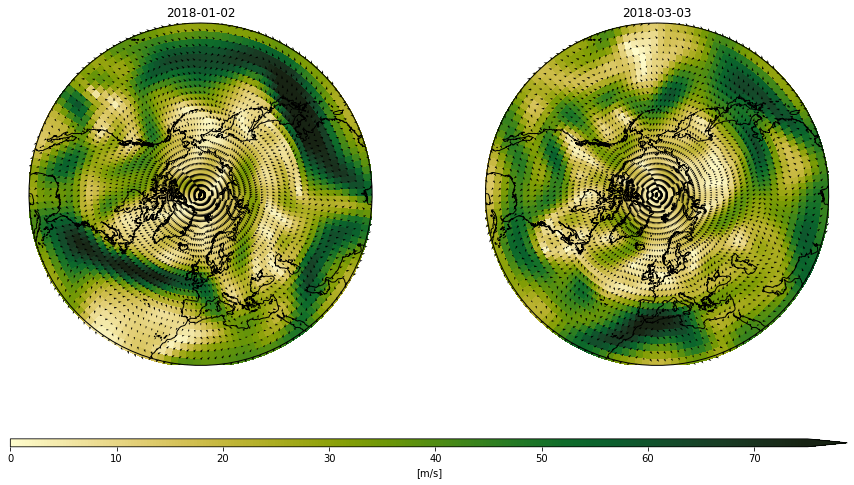

In [8]:
fignum = '07_14'

U = xr.open_dataset(datadir+'NCEP/uwnd.2018.nc').uwnd.sel(level=250).sel(lat=slice(90, 20))
V = xr.open_dataset(datadir+'NCEP/vwnd.2018.nc').vwnd.sel(level=250).sel(lat=slice(90, 20))
spd = np.hypot(U, V)
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
X, Y = np.meshgrid(spd.lon, spd.lat)

projection = cartopy.crs.NorthPolarStereo()
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': projection}, figsize=(15, 9))

time = ['2018-01-02', '2018-03-03']
for i in range(2):
    ax[i].coastlines(resolution='50m')

    a = ax[i].pcolormesh(cartopy.util.add_cyclic_point(spd.lon), spd.lat, 
                         cartopy.util.add_cyclic_point(spd.sel(time=time[i])), vmin=0, vmax=75,
                         cmap=cmo.speed, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ax[i].quiver(X, Y, U.sel(time=time[i]).values, V.sel(time=time[i]).values,
                 transform=cartopy.crs.PlateCarree())
    ax[i].set_extent([-180, 180, 20, 90], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_title(time[i])

plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='max', label='[m/s]')
savefig(fignum)

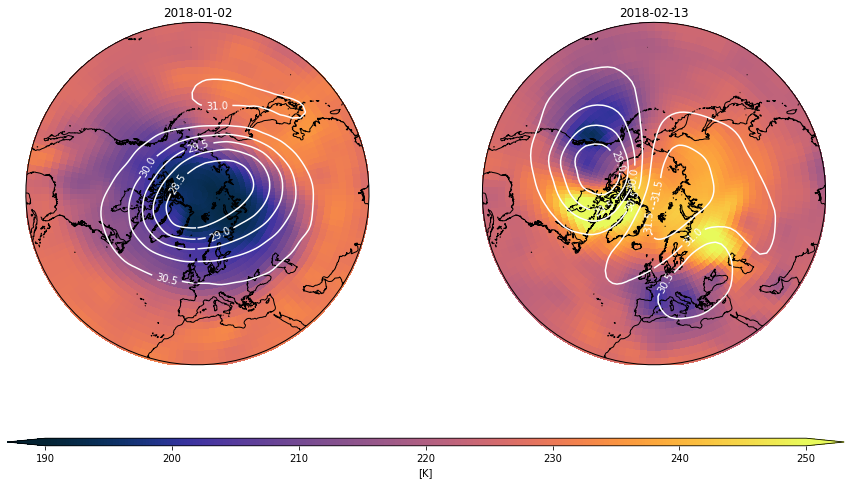

In [9]:
fignum = '07_15'

A = xr.open_dataset(datadir+'NCEP/air.2018.nc').air.sel(level=10).sel(lat=slice(90, 20))
H = xr.open_dataset(datadir+'NCEP/hgt.2018.nc').hgt.sel(level=10).sel(lat=slice(90, 20))

projection = cartopy.crs.NorthPolarStereo()
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': projection}, figsize=(15, 9))

time = ['2018-01-02', '2018-02-13']
for i in range(2):
    ax[i].coastlines(resolution='50m')

    a = ax[i].pcolormesh(cartopy.util.add_cyclic_point(A.lon), A.lat, 
                         cartopy.util.add_cyclic_point(A.sel(time=time[i])), vmin=190, vmax=250,
                         cmap=cmo.thermal, transform=cartopy.crs.PlateCarree(), rasterized=True)
    CS = ax[i].contour(H.lon, H.lat, H.sel(time=time[i])/1000., 
                     levels=np.arange(28.5, 32, 0.5), colors='w', transform=cartopy.crs.PlateCarree())
    ax[i].clabel(CS, inline=1, fontsize=10, fmt='%1.1f')
    ax[i].set_extent([-180, 180, 20, 90], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_title(time[i])

plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='both', label='[K]')
savefig(fignum)

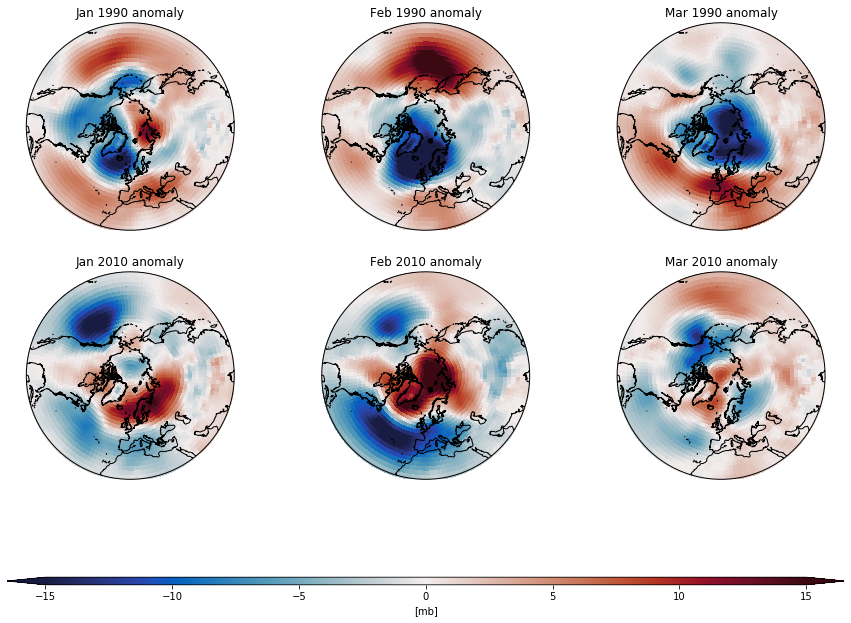

In [10]:
fignum = '07_16'

P = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=slice(90, 20))
climatology = P.groupby("time.month").mean("time")

projection = cartopy.crs.NorthPolarStereo()
fig, ax = plt.subplots(2, 3, subplot_kw={'projection': projection}, figsize=(15, 12))

for j, month in enumerate([1, 2, 3]):
    for i, yr in enumerate([1990, 2010]):
        ax[i, j].coastlines(resolution='50m')
        anom = P.sel(time='%d-%d-01' %(yr, month)) - climatology.sel(month=month)
        a = ax[i, j].pcolormesh(cartopy.util.add_cyclic_point(anom.lon), anom.lat, 
                             cartopy.util.add_cyclic_point(anom), vmin=-15, vmax=15,
                             cmap=cmo.balance, transform=cartopy.crs.PlateCarree(), rasterized=True)

        ax[i, j].set_extent([-180, 180, 20, 90], cartopy.crs.PlateCarree())
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax[i, j].set_boundary(circle, transform=ax[i, j].transAxes)
        ax[i, j].set_title('%s anomaly' % anom.time.dt.strftime('%b %Y').values)

plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='both', label='[mb]')
savefig(fignum)

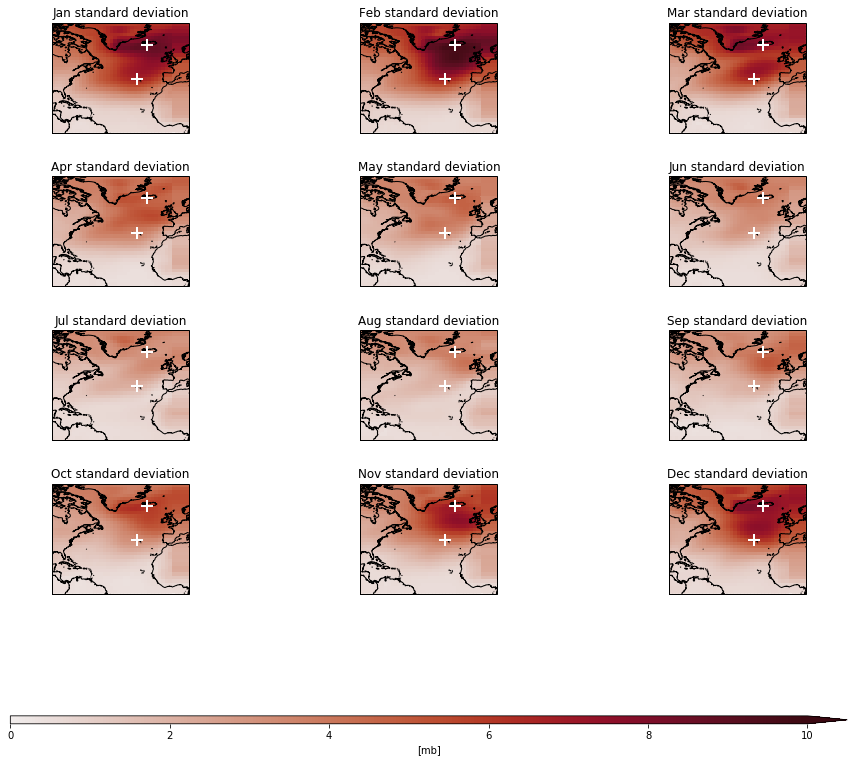

In [11]:
fignum = '07_16'

P = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=slice(80, 0))
P = P.isel(lon=(P.lon >= 270) | (P.lon <= 10))

projection = cartopy.crs.PlateCarree(central_longitude=-40)
fig, ax = plt.subplots(4, 3, subplot_kw={'projection': projection}, figsize=(15, 15))

for i, ai in enumerate(ax.ravel()):
    ai.coastlines(resolution='50m')
    anom = P.where(P.time.dt.month==i+1, drop=True)
    a = ai.pcolormesh(anom.lon, anom.lat, anom.std('time'), vmin=0, vmax=10,
                      cmap=cmo.amp, transform=cartopy.crs.PlateCarree(), rasterized=True)

    ai.plot([-21, -28], [64, 39], 'w+', markersize=12, markeredgewidth=2, transform=cartopy.crs.PlateCarree())
    ai.set_extent([-90, 10, 0, 80], cartopy.crs.PlateCarree())
    ai.set_title('%s standard deviation' % anom.time.dt.strftime('%b').values[0])

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='max', label='[mb]')
savefig(fignum)

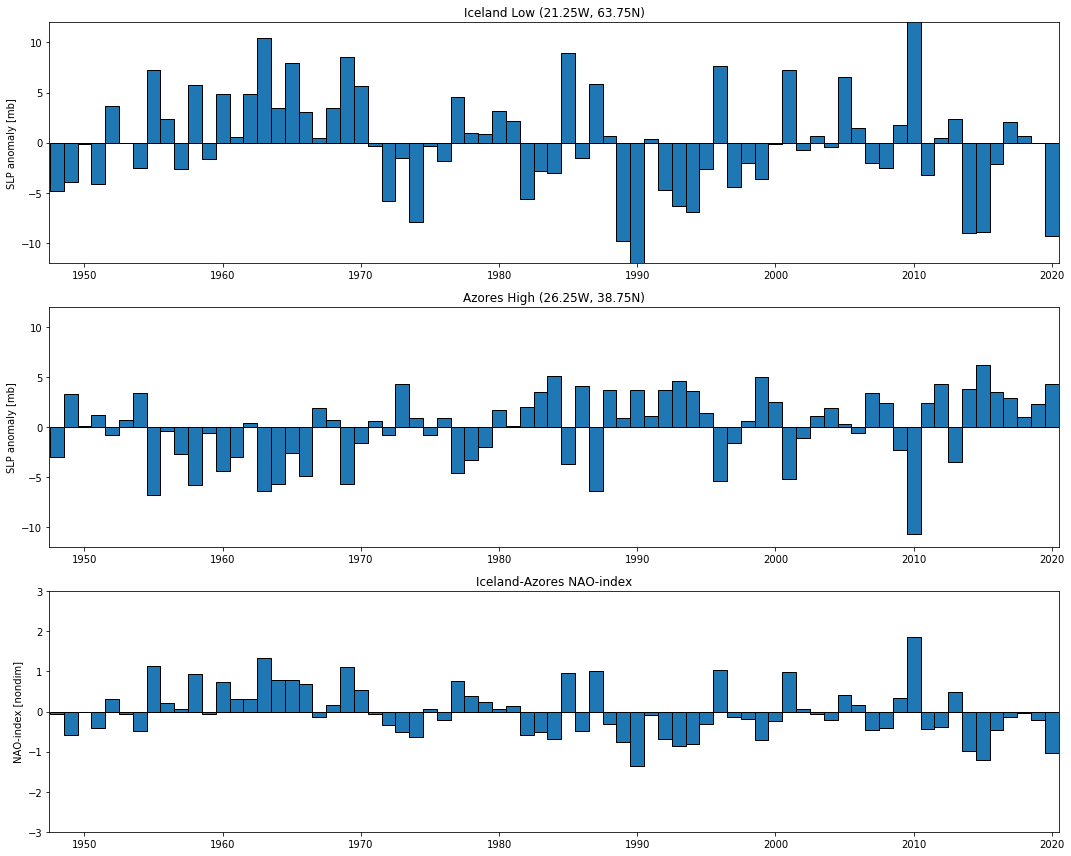

In [12]:
fignum = '07_18'

PR = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=63.75, lon=360-21.25, method='nearest')
decmar = [True if ((i%12 == 11) or (i%12 < 3)) else False for i in range(len(PR.time.values))]
PR = PR.where(decmar)
PR = PR.groupby("time.year").mean('time')
PR = PR - PR.mean('year')

PA = xr.open_dataset(datadir+'NCEP/slp.mon.mean.nc').slp.sel(lat=38.75, lon=360-26.25, method='nearest')
PA = PA.where(decmar)
PA = PA.groupby("time.year").mean('time')
PA = PA - PA.mean('year')

PD = PR / np.max(np.abs(PR)) - PA / np.max(np.abs(PA))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

for i, P in enumerate([PR, PA, PD]):
    ax[i].bar(P.year.values, P.values, width=1, linewidth=1, edgecolor='k')
    ax[i].set_xlim(P.year.values[0]-0.55, P.year.values[-1]+0.5)
    ylim = 12 if i < 2 else 3
    ax[i].set_ylim(-ylim, ylim)
    if i < 2:
        ax[i].set_ylabel('SLP anomaly [mb]')
    else:
        ax[i].set_ylabel('NAO-index [nondim]')        
ax[0].set_title('Iceland Low (21.25W, 63.75N)')
ax[1].set_title('Azores High (26.25W, 38.75N)')
ax[2].set_title('Iceland-Azores NAO-index')


plt.tight_layout()
savefig(fignum)

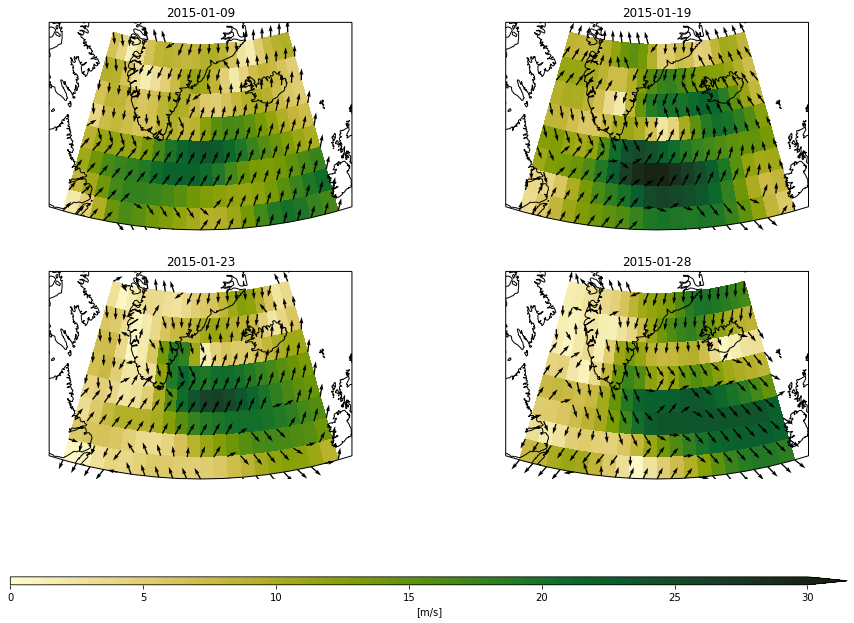

In [13]:
fignum = '07_14'

U = xr.open_dataset(datadir+'NCEP/uwnd.sig995.2015.nc').uwnd.sel(lat=slice(70, 50), lon=slice(300, 350))
V = xr.open_dataset(datadir+'NCEP/vwnd.sig995.2015.nc').vwnd.sel(lat=slice(70, 50), lon=slice(300, 350))
spd = np.hypot(U, V)
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
X, Y = np.meshgrid(spd.lon, spd.lat)

projection = cartopy.crs.LambertConformal(cutoff=50, central_longitude=-35)
fig, ax = plt.subplots(2, 2, subplot_kw={'projection': projection}, figsize=(15, 12))

time = ['2015-01-09', '2015-01-19', '2015-01-23', '2015-01-28']
for i, ai in enumerate(ax.ravel()):
    ai.coastlines(resolution='50m')

    a = ai.pcolormesh(spd.lon, spd.lat, spd.sel(time=time[i]), vmin=0, vmax=30,
                         cmap=cmo.speed, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.quiver(X, Y, U.sel(time=time[i]).values, V.sel(time=time[i]).values,
                 transform=cartopy.crs.PlateCarree())
    ai.set_title(time[i])

plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='max', label='[m/s]')
savefig(fignum)

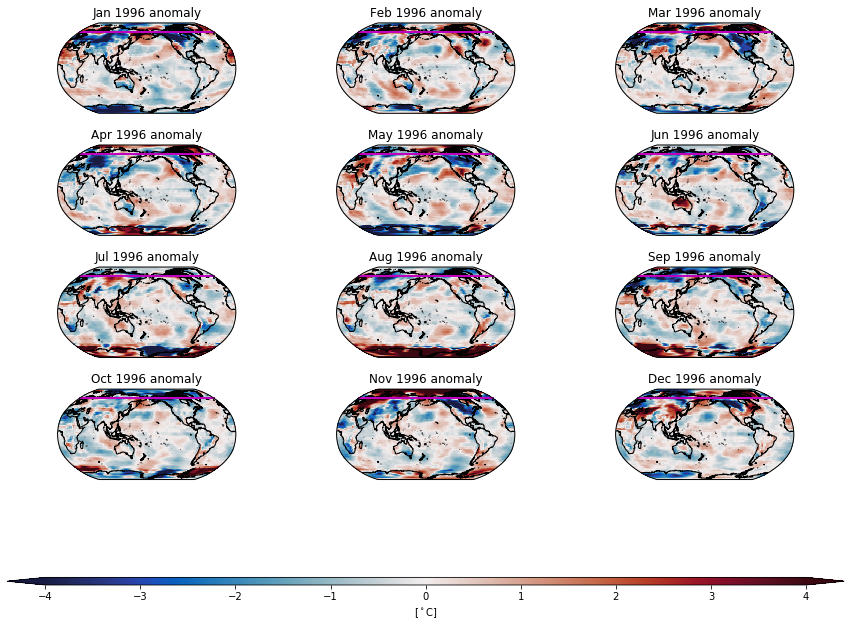

In [14]:
fignum = '07_36'

P = xr.open_dataset(datadir+'NCEP/air.mon.mean.nc').air
climatology = P.groupby("time.month").mean("time")
anomalies = P.groupby("time.month") - climatology

projection = cartopy.crs.Robinson(central_longitude=180)
fig, ax = plt.subplots(4, 3, subplot_kw={'projection': projection}, figsize=(15, 12))

for i, ai in enumerate(ax.ravel()):
    ai.coastlines(resolution='50m')
    p = anomalies.sel(time='1996-%.2d-01' % (i+1))
    a = p.plot(cmap=cmo.balance, vmin=-4, vmax=4,
               transform=cartopy.crs.PlateCarree(), 
               ax=ai, add_colorbar=False, rasterized=True)
    ai.plot([0, 360], [66, 66], transform=cartopy.crs.PlateCarree(), color='m', linewidth=2)
    ai.set_title('%s anomaly' % p.time.dt.strftime('%b %Y').values)

plt.subplots_adjust(hspace=0.35, wspace=0)
plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='both', label='[$^\circ$C]')
savefig(fignum)

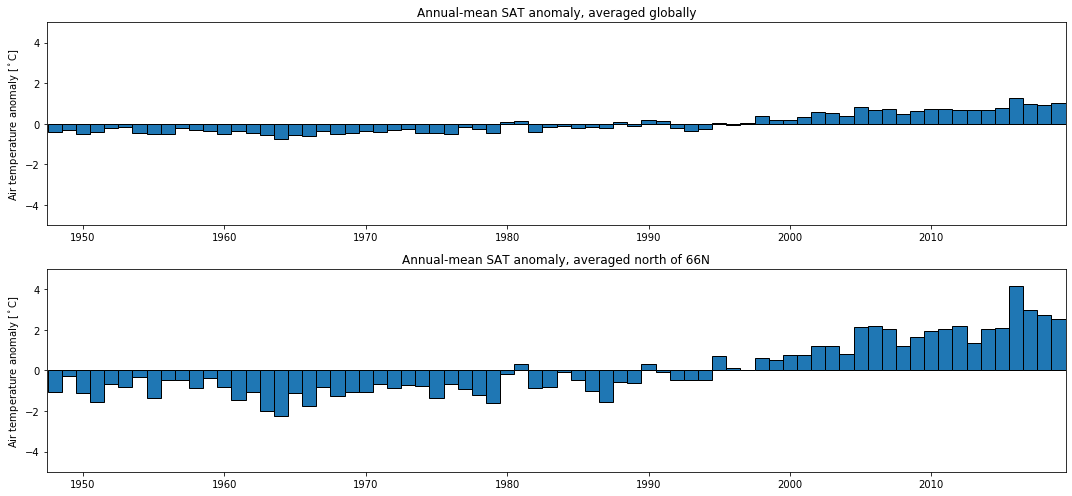

In [15]:
fignum = '07_37'

TG = xr.open_dataset(datadir+'NCEP/air.mon.mean.nc').air.mean('lon').mean('lat').sel(time=slice('1948-01-01', '2019-12-31'))
TA = xr.open_dataset(datadir+'NCEP/air.mon.mean.nc').air.sel(lat=slice(90, 66)).mean('lon').mean('lat').sel(time=slice('1948-01-01', '2019-12-31'))

# TG = .groupby("time.year").mean('time')

fig, ax = plt.subplots(2, 1, figsize=(15, 7))

for i, T in enumerate([TG, TA]):
    T = T.groupby("time.year").mean('time')
    ax[i].bar(T.year.values, (T - T.mean('year')).values, width=1, linewidth=1, edgecolor='k')
    ax[i].set_xlim(T.year.values[0]-0.55, T.year.values[-1]+0.5)
    ax[i].set_ylim(-5, 5)
    ax[i].set_ylabel('Air temperature anomaly [$^\circ$C]')
ax[0].set_title('Annual-mean SAT anomaly, averaged globally')
ax[1].set_title('Annual-mean SAT anomaly, averaged north of 66N')

plt.tight_layout()
savefig(fignum)

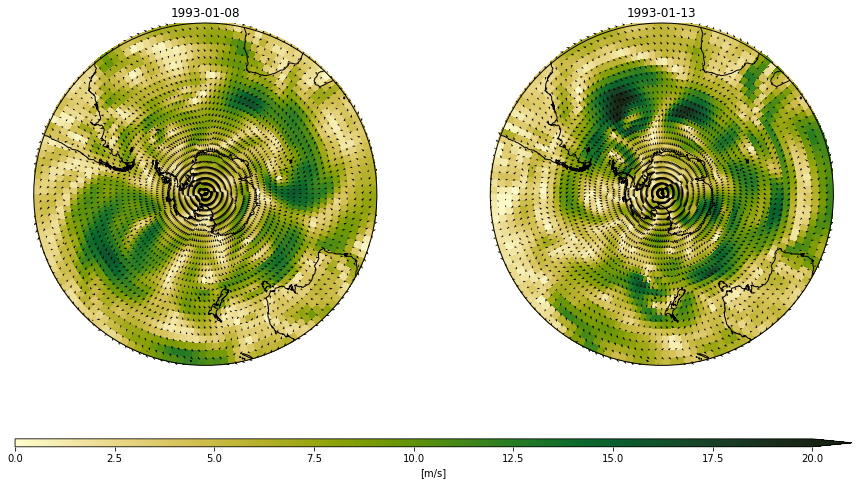

In [16]:
fignum = '08_12'

U = xr.open_dataset(datadir+'NCEP/uwnd.sig995.1993.nc').uwnd.sel(lat=slice(-20, -90))
V = xr.open_dataset(datadir+'NCEP/vwnd.sig995.1993.nc').vwnd.sel(lat=slice(-20, -90))
spd = np.hypot(U, V)
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
X, Y = np.meshgrid(spd.lon, spd.lat)

projection = cartopy.crs.SouthPolarStereo()
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': projection}, figsize=(15, 9))

time = ['1993-01-08', '1993-01-13']
for i in range(2):
    ax[i].coastlines(resolution='50m')

    a = ax[i].pcolormesh(cartopy.util.add_cyclic_point(spd.lon), spd.lat, 
                         cartopy.util.add_cyclic_point(spd.sel(time=time[i])), vmin=0, vmax=20,
                         cmap=cmo.speed, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ax[i].quiver(X, Y, U.sel(time=time[i]).values, V.sel(time=time[i]).values,
                 transform=cartopy.crs.PlateCarree())
    ax[i].set_extent([-180, 180, -90, -20], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_title(time[i])

plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='max', label='[m/s]')
savefig(fignum)

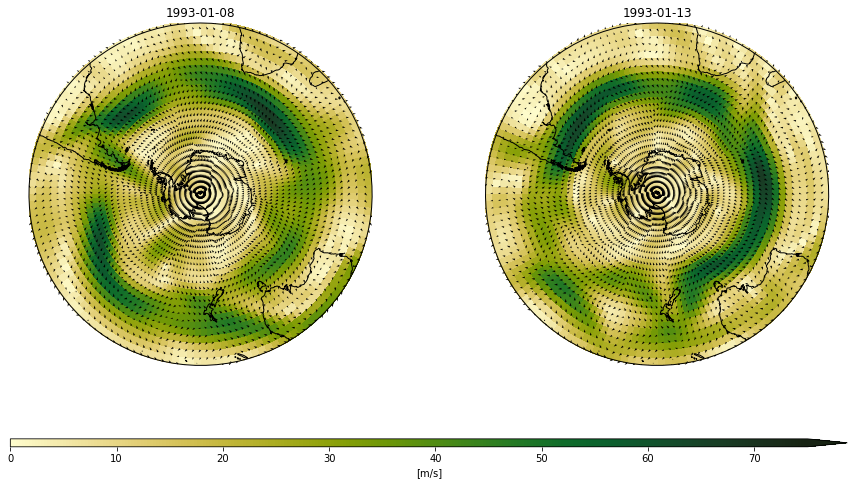

In [17]:
fignum = '08_13'

U = xr.open_dataset(datadir+'NCEP/uwnd.1993.nc').uwnd.sel(level=250, lat=slice(-20, -90))
V = xr.open_dataset(datadir+'NCEP/vwnd.1993.nc').vwnd.sel(level=250, lat=slice(-20, -90))
spd = np.hypot(U, V)
U = U / np.sqrt(U**2 + V**2);
V = V / np.sqrt(U**2 + V**2);
X, Y = np.meshgrid(spd.lon, spd.lat)

projection = cartopy.crs.SouthPolarStereo()
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': projection}, figsize=(15, 9))

time = ['1993-01-08', '1993-01-13']
for i in range(2):
    ax[i].coastlines(resolution='50m')

    a = ax[i].pcolormesh(cartopy.util.add_cyclic_point(spd.lon), spd.lat, 
                         cartopy.util.add_cyclic_point(spd.sel(time=time[i])), vmin=0, vmax=75,
                         cmap=cmo.speed, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ax[i].quiver(X, Y, U.sel(time=time[i]).values, V.sel(time=time[i]).values,
                 transform=cartopy.crs.PlateCarree())
    ax[i].set_extent([-180, 180, -90, -20], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_title(time[i])

plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='max', label='[m/s]')
savefig(fignum)

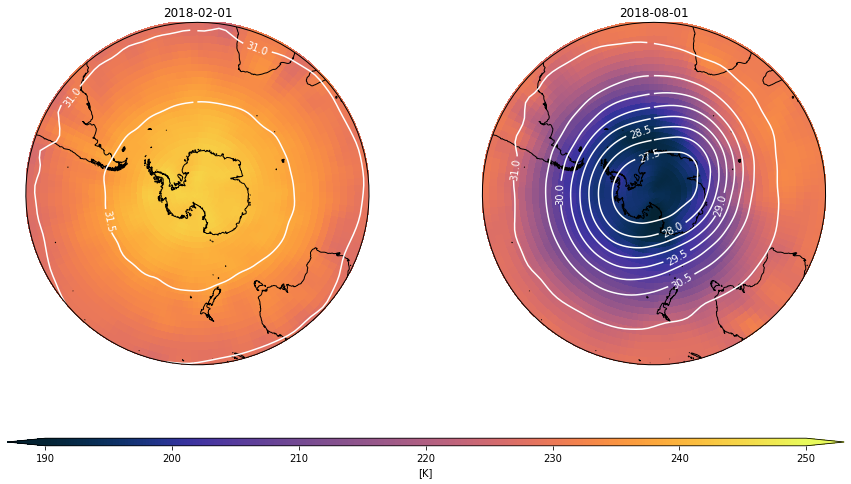

In [18]:
fignum = '08_14'

A = xr.open_dataset(datadir+'NCEP/air.2018.nc').air.sel(level=10).sel(lat=slice(-20, -90))
H = xr.open_dataset(datadir+'NCEP/hgt.2018.nc').hgt.sel(level=10).sel(lat=slice(-20, -90))

projection = cartopy.crs.SouthPolarStereo()
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': projection}, figsize=(15, 9))

time = ['2018-02-01', '2018-08-01']
for i in range(2):
    ax[i].coastlines(resolution='50m')

    a = ax[i].pcolormesh(cartopy.util.add_cyclic_point(A.lon), A.lat, 
                         cartopy.util.add_cyclic_point(A.sel(time=time[i])), vmin=190, vmax=250,
                         cmap=cmo.thermal, transform=cartopy.crs.PlateCarree(), rasterized=True)
    CS = ax[i].contour(H.lon, H.lat, H.sel(time=time[i])/1000., 
                     levels=np.arange(27, 32, 0.5), colors='w', transform=cartopy.crs.PlateCarree())
    ax[i].clabel(CS, inline=1, fontsize=10, fmt='%1.1f')
    ax[i].set_extent([-180, 180, -90, -20], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_title(time[i])

plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='both', label='[K]')
savefig(fignum)

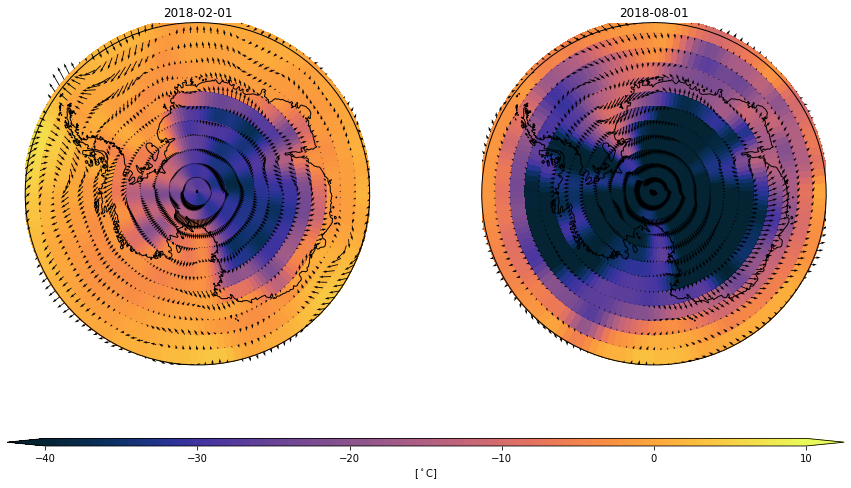

In [19]:
fignum = '08_15'

U = xr.open_dataset(datadir+'NCEP/uwnd.sig995.2018.nc').uwnd.sel(lat=slice(-60, -90))
V = xr.open_dataset(datadir+'NCEP/vwnd.sig995.2018.nc').vwnd.sel(lat=slice(-60, -90))
T = xr.open_dataset(datadir+'NCEP/air.sig995.2018.nc').air.sel(lat=slice(-60, -90))
X, Y = np.meshgrid(U.lon, U.lat)

projection = cartopy.crs.SouthPolarStereo()
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': projection}, figsize=(15, 9))

time = ['2018-02-01', '2018-08-01']
for i in range(2):
    ax[i].coastlines(resolution='50m')

    a = ax[i].pcolormesh(cartopy.util.add_cyclic_point(T.lon), T.lat, 
                         cartopy.util.add_cyclic_point(T.sel(time=time[i]))-273.15, vmin=-40, vmax=10,
                         cmap=cmo.thermal, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ax[i].quiver(X, Y, U.sel(time=time[i]).values, V.sel(time=time[i]).values,
                 transform=cartopy.crs.PlateCarree())
    ax[i].set_extent([-180, 180, -90, -60], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_title(time[i])

plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='both', label='[$^\circ$C]')
savefig(fignum)

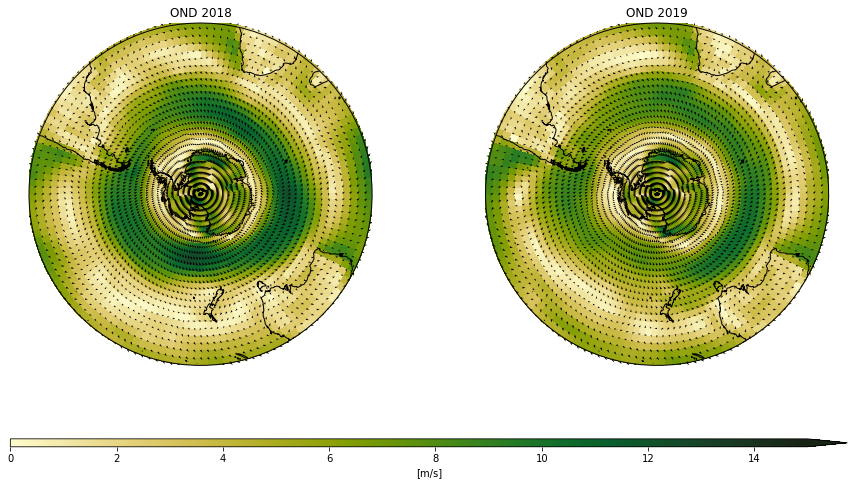

In [20]:
fignum = '08_17'

projection = cartopy.crs.SouthPolarStereo()
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': projection}, figsize=(15, 9))

for i, yr in enumerate([2018, 2019]):
    ax[i].coastlines(resolution='50m')

    U = xr.open_dataset(datadir+'NCEP/uwnd.sig995.%d.nc' % yr).uwnd.sel(lat=slice(-20, -90)).sel(time=slice('%d-10-01' % yr, '%d-12-31' % yr)).mean('time')
    V = xr.open_dataset(datadir+'NCEP/vwnd.sig995.%d.nc' % yr).vwnd.sel(lat=slice(-20, -90)).sel(time=slice('%d-10-01' % yr, '%d-12-31' % yr)).mean('time')
    spd = np.hypot(U, V)
    U = U / np.sqrt(U**2 + V**2);
    V = V / np.sqrt(U**2 + V**2);
    X, Y = np.meshgrid(spd.lon, spd.lat)

    a = ax[i].pcolormesh(cartopy.util.add_cyclic_point(spd.lon), spd.lat, 
                         cartopy.util.add_cyclic_point(spd), vmin=0, vmax=15,
                         cmap=cmo.speed, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ax[i].quiver(X, Y, U.values, V.values,
                 transform=cartopy.crs.PlateCarree())
    ax[i].set_extent([-180, 180, -90, -20], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_title('OND %d' % yr)

plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='max', label='[m/s]')
savefig(fignum)

In [21]:
figum = '08_36'

# TODO

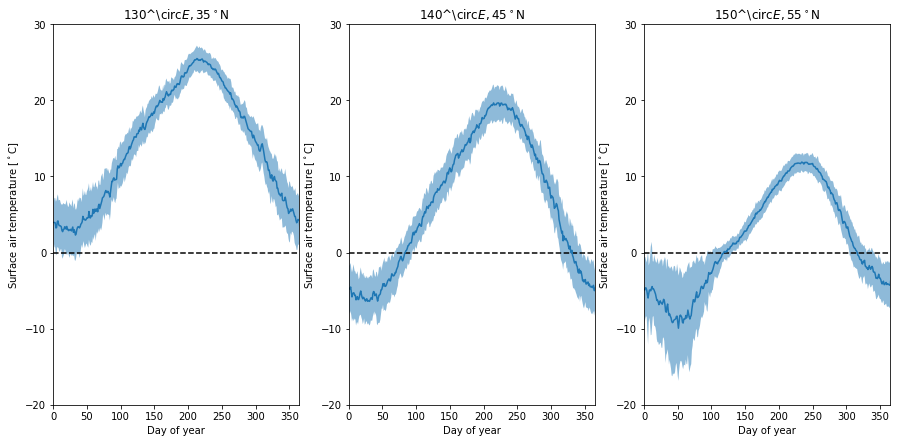

In [22]:
fignum = '09_30'

fig, ax = plt.subplots(1, 3, figsize=(15, 7))

lats = [35, 45, 55]
lons = [130, 140, 150]

for i in range(3):
    T = xr.open_mfdataset(datadir+'NCEP/air.sig995.*', combine='by_coords').air.sel(lat=lats[i], lon=lons[i], method='nearest')
    T = T.sel(time=slice('1965-01-01', '2015-12-31')) - 273.15
    mean = T.groupby('time.dayofyear').mean('time')
    std = T.groupby("time.dayofyear").std('time')

    ax[i].plot([0, 365], [0, 0], 'k--')
    ax[i].plot(mean.dayofyear, mean)
    ax[i].fill_between(mean.dayofyear, mean-std, mean+std, alpha=0.5)
    ax[i].set_xlabel('Day of year')
    ax[i].set_ylabel('Surface air temperature [$^\circ$C]')
    ax[i].set_xlim([0, 365])
    ax[i].set_ylim([-20, 30])
    ax[i].set_title('%d^\circ$E, %d^\circ$N' % (lons[i], lats[i]))

savefig(fignum)

In [23]:
figum = '09_31'

# TODO

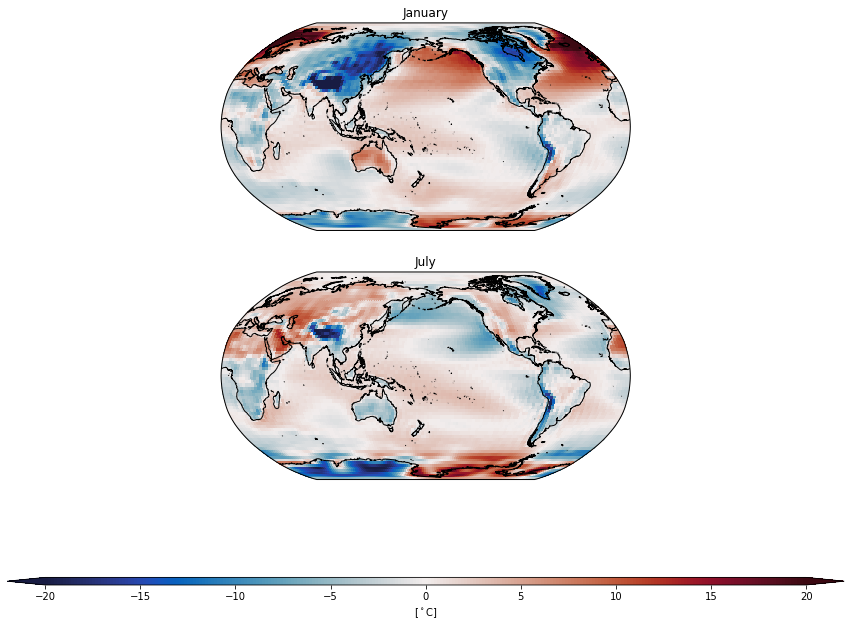

In [24]:
fignum = '11_22'

projection = cartopy.crs.Robinson(central_longitude=180)
fig, ax = plt.subplots(2, 1, subplot_kw={'projection': projection}, figsize=(15, 12))

for i, month in enumerate([1, 7]):
    ax[i].coastlines(resolution='50m')
    T = xr.open_mfdataset(datadir+'NCEP/air.sig995*', combine='by_coords').air
    temp = T.where(T.time.dt.month==month, drop=True)
    tempanom = temp.mean('time') - temp.mean('time').mean('lon')
    a = tempanom.plot(cmap=cmo.balance, vmin=-20, vmax=20,
                      transform=cartopy.crs.PlateCarree(),
                      ax=ax[i], add_colorbar=False, rasterized=True)
    ax[i].set_title('%s' % temp.time[0].dt.strftime('%B').values)

plt.colorbar(a, ax=ax.ravel().tolist(), orientation="horizontal", aspect=100, extend='both', label='[$^\circ$C]')
savefig(fignum)